In [47]:
import keras
from keras.models import Model, Input
from keras.layers import Conv2D, Activation, MaxPool2D, Flatten, Dense
from keras.layers import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import SGD
from keras.layers.advanced_activations import PReLU

from keras.utils import to_categorical

import numpy as np

from numpy.random import seed
seed(42)

import time

import matplotlib.pyplot as plt

# Magic numbers

In [79]:
nb_classes = 10
optim = SGD(lr=0.05)
batch_size = 128   # 128
epochs = 10        # 20
pix_ox, pix_oy = (28,28)

want_to_train = False

# Load the dataset

In [3]:
print(mnist.__file__)

/home/merlin/.virtualenvs/dl/lib/python3.6/site-packages/keras/datasets/mnist.py


In [59]:
(x_train_or, y_train_or), (x_test_or, y_test_or) = mnist.load_data()

# Inspect the dataset

In [51]:
print("Shape of x_train: ",x_train.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of x_test: ",x_test.shape)
print("Shape of y_test: ",y_test.shape)

Shape of x_train:  (60000, 28, 28)
Shape of y_train:  (60000,)
Shape of x_test:  (10000, 28, 28)
Shape of y_test:  (10000,)


# Reshape data to 4D tensors

In [63]:
x_train_or = np.reshape(x_train, (-1,pix_ox, pix_oy,1))
x_test_or = np.reshape(x_test, (-1,pix_ox, pix_oy, 1))

print("Shape of x_train: ",x_train.shape)
print("Shape of x_test: ",x_test.shape)

Shape of x_train:  (60000, 28, 28, 1)
Shape of x_test:  (10000, 28, 28, 1)


# Ensure float

In [53]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize the data

In [54]:
x_train = x_train / 255.
x_test = x_test / 255.

# One-hot encoding

In [55]:
print(y_train[544])

5


# Plot the image

TypeError: Invalid shape (28, 28, 1) for image data

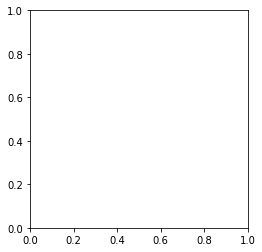

In [65]:
plt.imshow(x_train_or[544])

In [66]:
y_train_onehot = to_categorical(y_train, nb_classes)
y_test_onehot = to_categorical(y_test, nb_classes)

print(y_train_onehot[544])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


# The Model

In [67]:
def my_model(x):
    
    x = Conv2D(filters=4, kernel_size=(3,3), 
               strides=(1,1),padding= 'same', activation='relu')(x)

    x = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid')(x)
    
    x = Conv2D(filters=8, kernel_size=(3,3), 
               strides=(1,1),padding= 'same', activation='relu')(x)
    
    x = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid')(x)
    

    x = Flatten()(x)
    x = Dense(nb_classes, activation='softmax')(x)
    
    return x
      

# The Model big

In [78]:
def my_big_model(x):
    
    x = Conv2D(filters=32, kernel_size=(5,5), 
               strides=(1,1),padding= 'same')(x)
    x = PReLU()(x)
    x = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid')(x)
    
    x = Conv2D(filters=64, kernel_size=(5,5), 
               strides=(1,1),padding= 'same')(x)
    x = PReLU()(x)
    x = MaxPool2D(pool_size=(2,2), strides=(1,1), padding='valid')(x)
    
    x = Conv2D(filters=128, kernel_size=(3,3), 
               strides=(1,1),padding= 'same')(x)
    x = PReLU()(x)
    x = MaxPool2D(pool_size=(2,2), strides=(1,1), padding='valid')(x)
    
    x = Flatten()(x)
    x = Dense(50)(x)
    x = PReLU()(x)
    x = Dense(2)(x)
    x = PReLU(name='ghita')(x)
    
    x = Dense(nb_classes, activation='softmax')(x)
    
    return x

# Functional API

In [80]:
inputs = Input((pix_ox, pix_oy,1))
out = my_big_model(inputs)

model = Model(inputs=inputs, outputs=out)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
p_re_lu_5 (PReLU)            (None, 28, 28, 32)        25088     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 64)        51264     
_________________________________________________________________
p_re_lu_6 (PReLU)            (None, 14, 14, 64)        12544     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 13, 13, 64)        0         
__________

# Compile 

In [70]:
model.compile(loss="categorical_crossentropy", optimizer=optim, 
             metrics=['accuracy'])

# Callbacks

In [71]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.logs = []
        self.losses = []
        self.test_losses = []
        
        self.plot = plt.figure()
        
    def on_epoch_end(self, epoch, logs={}):
        self.x.append(self.i)
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.test_losses.append(logs.get('val_loss'))
        
        plt.plot(self.x, self.losses, label='train')
        plt.plot(self.x, self.test_losses, label='test')
        plt.show()
        
        self.i += 1
losses_train = PlotLosses()

# Train

In [82]:
if(want_to_train):
    start_time = time.time()
    model.fit(x_train, y_train_onehot,
             epochs=epochs,
             batch_size=batch_size,
             validation_data=(x_test, y_test_onehot),
             callbacks=[losses_train],
             verbose=1)
    end_time = time.time() - start_time

    print("Training time: ",end_time)
else:
    from keras.models import load_model

    model = load_model("my_big_model.h5")



# Print test accuracy

In [73]:
score = model.evaluate(x_test, y_test_onehot)

10000/10000 [==============================] - 1s 73us/step


In [74]:
print("accuracy: ",score[1])

accuracy:  0.9774


In [75]:
model.save("small_model.h5")

In [76]:
def plot_features(feats, y_test):
    c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
         '#ff00ff', '#990000', '#999900', '#009900', '#009999']
    
    for i in range(10):
        plt.plot(feats[y_test == i,0], 
                 feats[y_test == i,1], 
                 '.',c=c[i])
        
    plt.legend(['0','1','2','3','4','5','6','7','8','9'])
    plt.show()

In [83]:
model_reduced = Model(model.input, 
                      outputs=model.get_layer('ghita').output)

In [84]:
features = model_reduced.predict(x_test)

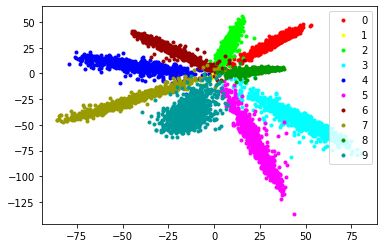

In [85]:
plot_features(features, y_test)

In [36]:
model.save("my_big_model.h5")